# Video-Model for B-Chef

In this notebool we will ~~try to~~ train own version of pre-trained model, called SlowFast

## Imports and defininigs

In [1]:
# !pip install torch torchvision torchaudio pytorchvideo --quiet
# !pip install omegaconf einops tqdm --quiet
# !apt install p7zip-full --quiet

import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm

In [2]:
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

In [3]:
!pip install mlflow --quiet
import mlflow
import mlflow.pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.6/752.6 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 25.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-api-core 1.3

In [4]:
BASE_DIR = "/kaggle/input/b-chef-tensors"

# CSV with metadata
TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
VAL_CSV   = os.path.join(BASE_DIR, "val.csv")
TEST_CSV  = os.path.join(BASE_DIR, "test.csv")
LABELS_SUMMARY = os.path.join(BASE_DIR, "labels_summary.csv")
KINETICS_CLASSES_FILE = os.path.join(BASE_DIR, "videomodel_classes_suitable.txt")

# folders with tesors
TENSORS_DIR = os.path.join(BASE_DIR, "tensors", "tensors")
TRAIN_DIR = os.path.join(TENSORS_DIR, "train")
VAL_DIR   = os.path.join(TENSORS_DIR, "val")
TEST_DIR  = os.path.join(TENSORS_DIR, "test")

# check
print("Train tensors:", os.listdir(TRAIN_DIR)[:5])
print("Val tensors:", os.listdir(VAL_DIR)[:5])
print("Test tensors:", os.listdir(TEST_DIR)[:5])
print("Train CSV exists:", os.path.exists(TRAIN_CSV))
print("Labels summary exists:", os.path.exists(LABELS_SUMMARY))


Train tensors: ['194_cut_slices.pt', '56_peel.pt', '241_peel.pt', '14_put_on_cutting-board.pt', '359_stir.pt']
Val tensors: ['65_put_on_plate.pt', '87_cut_slices.pt', '14_put_on_cutting-board.pt', '86_pour.pt', '49_cut_apart.pt']
Test tensors: ['14_cut_apart.pt', '31_pour.pt', '56_peel.pt', '11_peel.pt', '92_pour.pt']
Train CSV exists: True
Labels summary exists: True


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Work wth data

### Check that everything is accessible

In [6]:
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)
labels_summary = pd.read_csv(LABELS_SUMMARY)

print("Train CSV sample:")
display(train_df.head())

print("Labels summary:")
display(labels_summary)

Train CSV sample:


,filename,label
0,s10-d02-cam-002_23807_23844.avi,put_in_bowl
1,s10-d02-cam-002_7280_8569.avi,peel
2,s12-d10-cam-002_9017_9073.avi,cut_apart
3,s11-d12-cam-002_9131_9323.avi,put_on_plate
4,s16-d06-cam-002_9363_9547.avi,pour


Labels summary:


,label,count
0,cut_apart,75
1,cut_dice,75
2,cut_slices,74
3,grate,5
4,mix,8
5,open_egg,14
6,peel,75
7,pour,75
8,put_in_bowl,73
9,put_in_pan-pot,58


In [7]:
sample_file = os.listdir(TRAIN_DIR)[0]
sample_path = os.path.join(TRAIN_DIR, sample_file)
print("Loading:", sample_file)

tensor, label = torch.load(sample_path)
print("Tensor shape:", tensor.shape)
print("Label:", label)
# 32 frames, 3 channels (RGB), each frame size 224x224

Loading: 194_cut_slices.pt
Tensor shape: torch.Size([32, 3, 224, 224])
Label: cut_slices


In [8]:
with open(KINETICS_CLASSES_FILE, "r") as f:
    kinetics_classes = [line.strip() for line in f.readlines() if line.strip()]

non_kinetics_classes = sorted(labels_summary['label'].unique())

all_classes = sorted(set(kinetics_classes + non_kinetics_classes))
print(f"✅ Total classes: {len(all_classes)} ({len(kinetics_classes)} old + {len(non_kinetics_classes)} new)")



✅ Total classes: 25 (12 old + 13 new)


### Creating TensorVideoDataset

It is class that basically do the cell above for all files, but more convenient

In [9]:
class TensorVideoDataset(Dataset):
    def __init__(self, tensor_dir, csv_path, encoder=None, fit_encoder=False):
        self.tensor_dir = tensor_dir
        self.files = [f for f in os.listdir(tensor_dir) if f.endswith(".pt")]
        self.df = pd.read_csv(csv_path) if csv_path else None
        self.encoder = encoder
        if fit_encoder:
            labels = [f.split("_", 1)[1].replace(".pt", "") for f in self.files]
            self.encoder = LabelEncoder()
            self.encoder.fit(labels)


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.tensor_dir, self.files[idx])
        video_tensor, _ = torch.load(path)

        label_name = os.path.basename(path).split("_", 1)[1].replace(".pt", "")

        if label_name in all_classes:
            # label = torch.tensor(all_classes.index(label_name))
            if self.encoder:
                label = torch.tensor(self.encoder.transform([label_name])[0])
            else:
                label = label_name
        else:
            label = torch.tensor(-1)


        

        return video_tensor, label


In [10]:
# creating datasets
train_dataset = TensorVideoDataset(
    tensor_dir=TRAIN_DIR,
    csv_path=TRAIN_CSV,
    fit_encoder=True
)

val_dataset = TensorVideoDataset(
    tensor_dir=VAL_DIR,
    csv_path=VAL_CSV,
    encoder=train_dataset.encoder  # use same encoder
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")


Train samples: 529
Val samples:   114


### Create dataloaders

For batches, shuffling & iterations

In [11]:
def pad_collate(batch):
    # batch = [(video_tensor, label), ...]

    max_len = max(v.shape[0] for v, _ in batch)
    
    videos = []
    labels = []
    
    for v, l in batch:
        if v.shape[0] < max_len:
            pad = torch.zeros((max_len - v.shape[0], *v.shape[1:]))
            v = torch.cat([v, pad], dim=0)
        videos.append(v)
        labels.append(l)
    
    videos = torch.stack(videos)
    labels = torch.tensor(labels)
    
    return videos, labels


In [12]:
BATCH_SIZE = 8 if device.type == "cuda" else 2
print("Batch size set to:", BATCH_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)

val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

sample_batch = next(iter(train_loader))
videos, labels = sample_batch
print(f"Videos batch shape: {videos.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Labels: {labels}")


Batch size set to: 8
Videos batch shape: torch.Size([8, 32, 3, 224, 224])
Labels batch shape: torch.Size([8])
Labels: tensor([7, 9, 2, 9, 9, 8, 1, 6])


## Model


### simplest (and dumbest) version

In [13]:
import torch
import torch.nn as nn

class SlowFastModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.num_classes = num_classes

        # Slow path: low frame rate, extracts context
        self.slow_path = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=(1,2,2), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 14, 14))
        )

        # Fast path: high frame rate, extracts dynamics
        self.fast_path = nn.Sequential(
            nn.Conv3d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 14, 14))
        )

        self.fc = nn.Sequential(
            nn.Linear((32 + 8) * 4 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x: [B, T, C, H, W] -> [B, C, T, H, W]
        x = x.permute(0, 2, 1, 3, 4)

        # divide into slow and fast flows
        slow = x[:, :, ::8, :, :]  # take 1/8 frames
        fast = x                     # all frames

        # Conv3d + AdaptiveAvgPool3d
        slow_feat = self.slow_path(slow)
        fast_feat = self.fast_path(fast)

        # "flattening" tensors for fully con layer
        slow_feat = slow_feat.flatten(start_dim=1)
        fast_feat = fast_feat.flatten(start_dim=1)

        out = torch.cat([slow_feat, fast_feat], dim=1)

        return self.fc(out)


In [14]:
mlflow.set_tracking_uri("file:///kaggle/working/mlruns")
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("b-chef-slowfast")


2025/10/28 18:17:21 INFO mlflow.tracking.fluent: Experiment with name 'b-chef-slowfast' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///kaggle/working/mlruns/867290675062594529', creation_time=1761675441717, experiment_id='867290675062594529', last_update_time=1761675441717, lifecycle_stage='active', name='b-chef-slowfast', tags={}>

### pre-trained one with custom dataset

In [15]:
# import torch
# import torch.nn as nn
# from torchvision.models.video import slowfast_r50

# model = slowfast_r50(weights="KINETICS400_V1")  # 400 classes

# num_classes = 13
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


### pre-trained with combination of datasets

In [16]:
!pip install pytorchvideo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 40.6 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=c5a5c00369e6fbe0702044deecc02064c4ba9d9962f94004252e457178a2c144
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=da78acf54f177c77ee3da5601a71b8403e23e1002fdab4af6c66898ea926ae77
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel f

In [17]:
import torch
import torch.nn as nn
from pytorchvideo.models.hub import slowfast_r50

device = "cuda" if torch.cuda.is_available() else "cpu"

# create model
model = slowfast_r50(pretrained=True)

# check architecture
# print(model)


Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50.pyth
100%|██████████| 264M/264M [00:00<00:00, 314MB/s]


In [18]:
# old outputs
old_head = model.blocks[-1].proj  # Kinetics400
in_features = old_head.in_features

# new layer
new_head = nn.Linear(in_features, len(all_classes))

# copy weoghts for kinetics
with torch.no_grad():
    new_head.weight[:len(kinetics_classes)] = old_head.weight[:len(kinetics_classes)]
    new_head.bias[:len(kinetics_classes)] = old_head.bias[:len(kinetics_classes)]

# replace
model.blocks[-1].proj = new_head
model = model.to(device)

# freeze
for name, param in model.named_parameters():
    if "blocks.6.proj" not in name:
        param.requires_grad = False

print(f"Output layer: {len(all_classes)} classes")

Output layer: 25 classes


In [19]:
from torch.nn import AdaptiveAvgPool3d

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    alpha = 4
    min_slow_T = 4 
    
    loop = tqdm(dataloader, desc=f"⚙️ Train Epoch {epoch+1}", leave=False)
    for inputs, labels in loop:
        inputs = inputs.permute(0, 2, 1, 3, 4).to(device)  # [B, C, T, H, W]
        labels = labels.long().to(device)

        fast_inputs = inputs
        slow_inputs = inputs[:, :, ::alpha, :, :]

        if slow_inputs.size(2) < min_slow_T:
            B, C, T, H, W = slow_inputs.shape
            new_slow_inputs = torch.zeros(B, C, min_slow_T, H, W, device=device)
            
            if T > 0:
                frames_to_copy = min(T, min_slow_T)
                new_slow_inputs[:, :, :frames_to_copy] = slow_inputs[:, :, :frames_to_copy]
            
            if T < min_slow_T:
                last_frame = slow_inputs[:, :, -1:].expand(-1, -1, min_slow_T - T, -1, -1)
                new_slow_inputs[:, :, T:] = last_frame
            
            slow_inputs = new_slow_inputs

        model.blocks[5].pool[1] = AdaptiveAvgPool3d((1, 7, 7))  # fast path
        model.blocks[5].pool[0] = AdaptiveAvgPool3d((1, 7, 7))  # slow path
        
        optimizer.zero_grad()
        outputs = model([slow_inputs, fast_inputs])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

    train_loss = running_loss / len(dataloader)
    train_acc = 100 * correct / total

    mlflow.log_metric("train_loss", train_loss, step=epoch)
    mlflow.log_metric("train_acc", train_acc, step=epoch)

    return train_loss, train_acc


@torch.no_grad()
def validate(model, dataloader, criterion, device, epoch):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    alpha = 4
    min_slow_T = 4

    loop = tqdm(dataloader, desc=f"🔍 Val Epoch {epoch+1}", leave=False)
    for inputs, labels in loop:
        inputs = inputs.permute(0, 2, 1, 3, 4).to(device)
        labels = labels.long().to(device)

        fast_inputs = inputs
        slow_inputs = inputs[:, :, ::alpha, :, :]

        if slow_inputs.size(2) < min_slow_T:
            B, C, T, H, W = slow_inputs.shape
            new_slow_inputs = torch.zeros(B, C, min_slow_T, H, W, device=device)
            
            if T > 0:
                frames_to_copy = min(T, min_slow_T)
                new_slow_inputs[:, :, :frames_to_copy] = slow_inputs[:, :, :frames_to_copy]
            
            if T < min_slow_T:
                last_frame = slow_inputs[:, :, -1:].expand(-1, -1, min_slow_T - T, -1, -1)
                new_slow_inputs[:, :, T:] = last_frame
            
            slow_inputs = new_slow_inputs

        model.blocks[5].pool[1] = AdaptiveAvgPool3d((1, 7, 7))  # fast path
        model.blocks[5].pool[0] = AdaptiveAvgPool3d((1, 7, 7))  # slow path
        
        
        outputs = model([slow_inputs, fast_inputs])
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

    val_loss /= len(dataloader)
    val_acc = 100 * correct / total

    mlflow.log_metric("val_loss", val_loss, step=epoch)
    mlflow.log_metric("val_acc", val_acc, step=epoch)

    return val_loss, val_acc

In [20]:
num_classes = len(all_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
num_epochs = 100

train_losses, train_accs, val_losses, val_accs = [], [], [], []

patience = 7
min_delta = 0.1
best_val_acc = 0.0
epochs_without_improvement = 0

with mlflow.start_run(run_name="slowfast_v3_delta"):
    mlflow.log_params({
        "num_classes": num_classes,
        "lr": 1e-4,
        "epochs": num_epochs,
        "optimizer": "Adam",
        "batch_size": train_loader.batch_size,
        "patience": patience,
        "min_delta": min_delta
    })
    
    for epoch in range(num_epochs):
        print(f"\n🌍 Epoch [{epoch+1}/{num_epochs}]")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
        val_loss, val_acc = validate(model, val_loader, criterion, device, epoch)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"📈 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"🧪 Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

        improvement = val_acc - best_val_acc
        
        if improvement > min_delta:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            mlflow.pytorch.log_model(pytorch_model=model, name="best_model")
            print(f"💾 Best model updated! (+{improvement:.2f}%)")
        elif improvement > 0:
            best_val_acc = val_acc
            epochs_without_improvement = 0
            print(f"📈 Small improvement: +{improvement:.2f}% (below delta)")
        else:
            epochs_without_improvement += 1
            print(f"📉 No improvement for {epochs_without_improvement} epoch(s)")
            
            if epochs_without_improvement >= patience:
                print(f"🛑 Early stopping at epoch {epoch+1}. Best val acc: {best_val_acc:.2f}%")
                break

    mlflow.log_metric("best_val_acc", best_val_acc)
    mlflow.log_metric("final_val_acc", val_accs[-1])
    mlflow.log_metric("total_epochs_trained", epoch + 1)


🌍 Epoch [1/100]


📈 Train Loss: 3.2472 | Train Acc: 17.20%
🧪 Val   Loss: 2.8021 | Val   Acc: 22.81%


2025/10/28 18:19:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:19:31 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:19:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+22.81%)

🌍 Epoch [2/100]


📈 Train Loss: 2.8047 | Train Acc: 18.90%
🧪 Val   Loss: 2.6138 | Val   Acc: 25.44%


2025/10/28 18:20:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:20:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:20:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+2.63%)

🌍 Epoch [3/100]


📈 Train Loss: 2.6544 | Train Acc: 17.58%
🧪 Val   Loss: 2.5466 | Val   Acc: 27.19%


2025/10/28 18:21:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:21:41 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:21:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+1.75%)

🌍 Epoch [4/100]


📈 Train Loss: 2.5962 | Train Acc: 19.66%
🧪 Val   Loss: 2.4719 | Val   Acc: 29.82%


2025/10/28 18:22:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:22:46 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:22:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+2.63%)

🌍 Epoch [5/100]


📈 Train Loss: 2.5124 | Train Acc: 22.68%
🧪 Val   Loss: 2.4142 | Val   Acc: 28.95%
📉 No improvement for 1 epoch(s)

🌍 Epoch [6/100]


📈 Train Loss: 2.4313 | Train Acc: 25.33%
🧪 Val   Loss: 2.3443 | Val   Acc: 32.46%


2025/10/28 18:24:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:24:45 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:24:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+2.63%)

🌍 Epoch [7/100]


📈 Train Loss: 2.3588 | Train Acc: 25.52%
🧪 Val   Loss: 2.2793 | Val   Acc: 32.46%
📉 No improvement for 1 epoch(s)

🌍 Epoch [8/100]


📈 Train Loss: 2.3165 | Train Acc: 29.87%
🧪 Val   Loss: 2.2503 | Val   Acc: 33.33%


2025/10/28 18:26:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:26:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:26:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+0.88%)

🌍 Epoch [9/100]


📈 Train Loss: 2.2287 | Train Acc: 31.95%
🧪 Val   Loss: 2.2020 | Val   Acc: 35.09%


2025/10/28 18:27:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:27:49 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:27:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+1.75%)

🌍 Epoch [10/100]


📈 Train Loss: 2.1874 | Train Acc: 32.14%
🧪 Val   Loss: 2.1717 | Val   Acc: 34.21%
📉 No improvement for 1 epoch(s)

🌍 Epoch [11/100]


📈 Train Loss: 2.1422 | Train Acc: 31.57%
🧪 Val   Loss: 2.1134 | Val   Acc: 35.96%


2025/10/28 18:29:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:29:49 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:29:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+0.88%)

🌍 Epoch [12/100]


📈 Train Loss: 2.1113 | Train Acc: 33.84%
🧪 Val   Loss: 2.0802 | Val   Acc: 35.96%
📉 No improvement for 1 epoch(s)

🌍 Epoch [13/100]


📈 Train Loss: 2.0892 | Train Acc: 34.59%
🧪 Val   Loss: 2.0533 | Val   Acc: 34.21%
📉 No improvement for 2 epoch(s)

🌍 Epoch [14/100]


📈 Train Loss: 2.0245 | Train Acc: 36.48%
🧪 Val   Loss: 2.0106 | Val   Acc: 36.84%


2025/10/28 18:32:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:32:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:32:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+0.88%)

🌍 Epoch [15/100]


📈 Train Loss: 1.9555 | Train Acc: 39.51%
🧪 Val   Loss: 1.9726 | Val   Acc: 40.35%


2025/10/28 18:33:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:33:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:33:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+3.51%)

🌍 Epoch [16/100]


📈 Train Loss: 1.8810 | Train Acc: 40.08%
🧪 Val   Loss: 1.9418 | Val   Acc: 37.72%
📉 No improvement for 1 epoch(s)

🌍 Epoch [17/100]


📈 Train Loss: 1.8818 | Train Acc: 40.83%
🧪 Val   Loss: 1.9305 | Val   Acc: 41.23%


2025/10/28 18:35:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:35:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:35:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+0.88%)

🌍 Epoch [18/100]


📈 Train Loss: 1.8413 | Train Acc: 43.48%
🧪 Val   Loss: 1.9293 | Val   Acc: 38.60%
📉 No improvement for 1 epoch(s)

🌍 Epoch [19/100]


📈 Train Loss: 1.7967 | Train Acc: 44.23%
🧪 Val   Loss: 1.8819 | Val   Acc: 38.60%
📉 No improvement for 2 epoch(s)

🌍 Epoch [20/100]


📈 Train Loss: 1.7604 | Train Acc: 44.42%
🧪 Val   Loss: 1.8261 | Val   Acc: 42.11%


2025/10/28 18:38:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:38:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/28 18:38:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Best model updated! (+0.88%)

🌍 Epoch [21/100]


📈 Train Loss: 1.7179 | Train Acc: 45.94%
🧪 Val   Loss: 1.8139 | Val   Acc: 42.11%
📉 No improvement for 1 epoch(s)

🌍 Epoch [22/100]


📈 Train Loss: 1.7175 | Train Acc: 45.75%
🧪 Val   Loss: 1.8186 | Val   Acc: 40.35%
📉 No improvement for 2 epoch(s)

🌍 Epoch [23/100]


📈 Train Loss: 1.6698 | Train Acc: 49.15%
🧪 Val   Loss: 1.7728 | Val   Acc: 40.35%
📉 No improvement for 3 epoch(s)

🌍 Epoch [24/100]


📈 Train Loss: 1.6512 | Train Acc: 46.69%
🧪 Val   Loss: 1.7421 | Val   Acc: 42.11%
📉 No improvement for 4 epoch(s)

🌍 Epoch [25/100]


📈 Train Loss: 1.6202 | Train Acc: 48.02%
🧪 Val   Loss: 1.7414 | Val   Acc: 40.35%
📉 No improvement for 5 epoch(s)

🌍 Epoch [26/100]


📈 Train Loss: 1.6091 | Train Acc: 51.98%
🧪 Val   Loss: 1.7255 | Val   Acc: 42.11%
📉 No improvement for 6 epoch(s)

🌍 Epoch [27/100]


📈 Train Loss: 1.5882 | Train Acc: 51.61%
🧪 Val   Loss: 1.7188 | Val   Acc: 41.23%
📉 No improvement for 7 epoch(s)
🛑 Early stopping at epoch 27. Best val acc: 42.11%


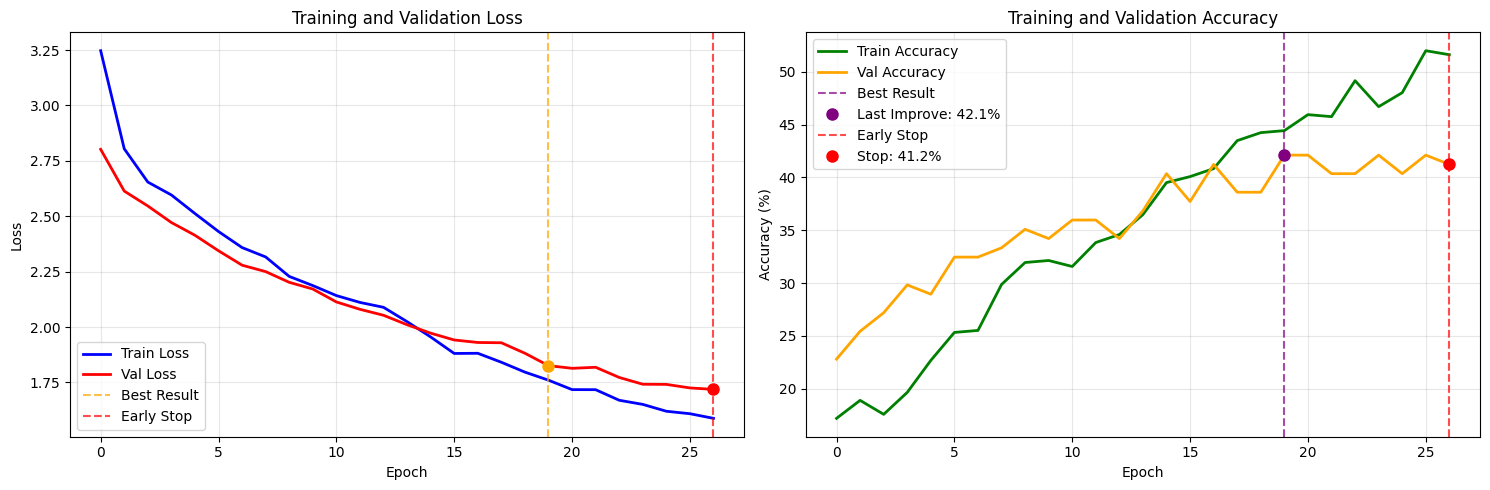

📊 Last Train Accuracy: 51.61%
📊 Last Val Accuracy: 41.23%
🏆 Best Val Accuracy: 42.11% (epoch 20)
🔄 Last improvement at epoch: 20 (acc: 42.11%)
🛑 Early stopping at epoch: 27 (acc: 41.23%)
⏳ Patience period: 7 epochs


In [21]:
import matplotlib.pyplot as plt

if len(train_accs) < num_epochs:
    early_stop_epoch = len(train_accs)
    early_stop_acc = val_accs[-1]
    
    patience_start_epoch = early_stop_epoch - epochs_without_improvement
    patience_start_acc = val_accs[patience_start_epoch - 1] if patience_start_epoch > 0 else val_accs[0]
else:
    early_stop_epoch = None
    patience_start_epoch = None

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(val_losses, 'r-', label='Val Loss', linewidth=2)

if early_stop_epoch:
    plt.axvline(x=patience_start_epoch-1, color='orange', linestyle='--', alpha=0.7, label='Best Result')
    plt.plot(patience_start_epoch-1, val_losses[patience_start_epoch-1], 'o', color='orange', markersize=8)
    
    plt.axvline(x=early_stop_epoch-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
    plt.plot(early_stop_epoch-1, val_losses[-1], 'ro', markersize=8)

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, 'g-', label='Train Accuracy', linewidth=2)
plt.plot(val_accs, 'orange', label='Val Accuracy', linewidth=2)

if early_stop_epoch:
    plt.axvline(x=patience_start_epoch-1, color='purple', linestyle='--', alpha=0.7, label='Best Result')
    plt.plot(patience_start_epoch-1, patience_start_acc, 'o', color='purple', markersize=8, 
             label=f'Last Improve: {patience_start_acc:.1f}%')
    
    plt.axvline(x=early_stop_epoch-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
    plt.plot(early_stop_epoch-1, early_stop_acc, 'ro', markersize=8, 
             label=f'Stop: {early_stop_acc:.1f}%')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_val_acc = max(val_accs)
best_epoch = val_accs.index(best_val_acc) + 1
print(f"📊 Last Train Accuracy: {train_accs[-1]:.2f}%")
print(f"📊 Last Val Accuracy: {val_accs[-1]:.2f}%")
print(f"🏆 Best Val Accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
if early_stop_epoch:
    print(f"🔄 Last improvement at epoch: {patience_start_epoch} (acc: {patience_start_acc:.2f}%)")
    print(f"🛑 Early stopping at epoch: {early_stop_epoch} (acc: {early_stop_acc:.2f}%)")
    print(f"⏳ Patience period: {epochs_without_improvement} epochs")

📊 Found 12 classes in validation data:
  0: cut_apart
  1: cut_dice
  2: cut_slices
  3: mix
  4: open_egg
  5: peel
  6: pour
  7: put_in_bowl
  8: put_in_pan-pot
  9: put_on_cutting-board
  10: put_on_plate
  11: stir


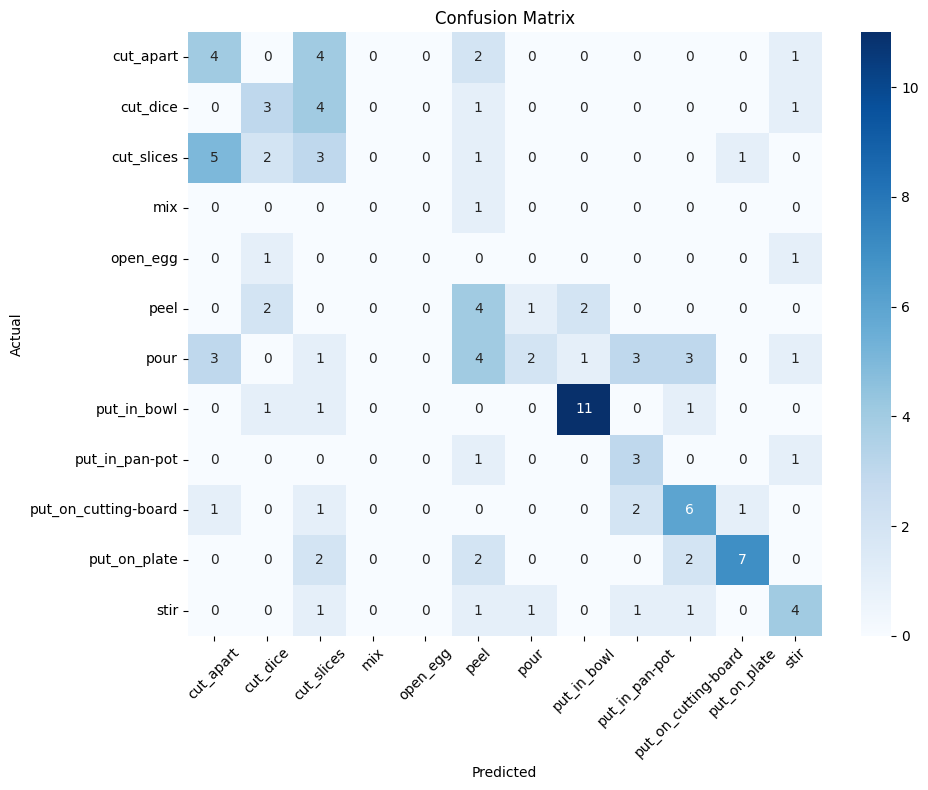


📊 Classification Report:
                      precision    recall  f1-score   support

           cut_apart       0.31      0.36      0.33        11
            cut_dice       0.33      0.33      0.33         9
          cut_slices       0.18      0.25      0.21        12
                 mix       0.00      0.00      0.00         1
            open_egg       0.00      0.00      0.00         2
                peel       0.24      0.44      0.31         9
                pour       0.50      0.11      0.18        18
         put_in_bowl       0.79      0.79      0.79        14
      put_in_pan-pot       0.33      0.60      0.43         5
put_on_cutting-board       0.46      0.55      0.50        11
        put_on_plate       0.78      0.54      0.64        13
                stir       0.44      0.44      0.44         9

            accuracy                           0.41       114
           macro avg       0.36      0.37      0.35       114
        weighted avg       0.45      0.41 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, dataloader, encoder, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.permute(0, 2, 1, 3, 4).to(device)
            
            # SlowFast inputs
            fast_inputs = inputs
            slow_inputs = inputs[:, :, ::4, :, :]
            
            outputs = model([slow_inputs, fast_inputs])
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    unique_labels = np.unique(all_labels)
    actual_classes = [encoder.classes_[i] for i in unique_labels]
    
    print(f"📊 Found {len(unique_labels)} classes in validation data:")
    for i, class_name in enumerate(actual_classes):
        print(f"  {i}: {class_name}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=actual_classes, 
                yticklabels=actual_classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, 
                               target_names=actual_classes,
                               labels=unique_labels))

plot_confusion_matrix(model, val_loader, train_dataset.encoder, device)